In [1]:
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import lifelines

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from keras import layers, initializers, optimizers, losses

from tensorflow.keras.callbacks import Callback
from tqdm.keras import TqdmCallback
from tqdm import tqdm

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

2025-10-14 15:15:42.417722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760465742.435701 1177508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760465742.441320 1177508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760465742.454841 1177508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760465742.454867 1177508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760465742.454870 1177508 computation_placer.cc:177] computation placer alr

In order for we to not have to import tensorflow every time we want to test something. Development for the models will be made here and then migrated to the proper .py files.


In [ ]:
class FrailtyModelNN(keras.models.Model):

    def __init__(self, parameters, loglikelihood_loss, neural_network_structure = None, neural_network_call = None, input_dim = None, seed = None):
        super().__init__()
        self.parameters = parameters
        self.loglikelihood_loss = loglikelihood_loss
        self.neural_network_structure = neural_network_structure
        self.neural_network_call = neural_network_call
        self.n_acum_step = tf.Variable(0, dtype = tf.int32, trainable = False)

        self.input_dim = input_dim
        self.seed = seed

        if(input_dim is not None):
            self.define_structure(input_dim)
    
    def define_structure(self, input_dim):
        # Goes through the list of parameters for the model and filter them by their classes:
        # - "nn" will be treated as an output from a given neural network that receives the variables x as input.
        # - "independet" will be treated an an individual tf.Variable, trainable object. It is still trained in tensorflow, but is constant for all subjects
        # - "fixed" will be treated as a non-trainable tf.Variable. Basically just a known constant.
        # - "manual" will be treated as a non-trainable tf.Variable, but its value will be eventually updated manually using user provided functions (useful in cases where closed forms can be obtained)
        # - "dependent" will be treated simply as a deterministic function of other parameters and will be updated after training

        self.nn_pars = []
        self.independent_pars = []
        self.fixed_pars = []
        self.manual_pars = []
        for parameter in self.parameters:
            par = self.parameters[parameter]
            if(par["par_type"] == "nn"):
                self.nn_pars.append( parameter )
            elif(par["par_type"] == "independent"):
                self.independent_pars.append( parameter )
            elif(par["par_type"] == "fixed"):
                self.fixed_pars.append( parameter )
            elif(par["par_type"] == "manual"):
                self.manual_pars.append( parameter )
            else:
                raise Exception("Invalid parameter {} type: {}".format(parameter, par["par_type"]))

        # If at least one parameter is to be modeled as a neural network output, define its architecture here
        if( len(self.nn_pars) > 0 ):
            if(self.neural_network_structure is None):
                raise Exception("Parameters {} defined as 'nn'. Please, provide a structure for their neural network.".format(self.nn_pars))
            # Define the neural network structure based on the user's input
            self.neural_network_structure(self, self.seed)

        # Dictionary with all parameters that are its individual weights
        self.model_variables = {}

        # Include variables that do not depend on the variables x, but are still trained by tensorflow
        for parameter in self.independent_pars:
            par = self.parameters[parameter]

            # If shape is None, set it to ()
            if(par["shape"] is None):
                par["shape"] = ()

            raw_init = par["link_inv"]( par["init"] )

            # Name for the new, transformed parameter
            raw_parameter = "raw_" + parameter
            self.model_variables[raw_parameter] = self.add_weight(
                name = raw_parameter,
                shape = par["shape"],
                initializer = keras.initializers.Constant( raw_init ),
                trainable = True,
                dtype = tf.float32
            )

        # Include variables that are not trained by tensorflow (known, fixed constants or manual trained variables)
        for parameter in np.concatenate([self.fixed_pars, self.manual_pars]):
            par = self.parameters[parameter]
            self.model_variables[parameter] = self.add_weight(
                name = parameter,
                shape = par["shape"],
                initializer = keras.initializers.Constant( par["initializer"] ),
                trainable = False,
                dtype = tf.float32
            )

        # Organize trainable variables information, so each variable can get mapped to an index in the self.trainable_variables and its gradients
        self.vars_to_index = {}
        # Before we build the model, the only variables that appear in here are the ones corresponding to "independent" parameters
        for i, var in enumerate(self.trainable_variables):
            # From the variable path, get its name (raw_<variable>)
            var_name = var.path.split("/")[-1]
            # Save its corresponding index
            self.vars_to_index[var_name] = i

        nn_par_index = 0
        # We must also include in this list the indices for "nn" parameters
        for i, parameter in enumerate(self.nn_pars):
            par = self.parameters[ parameter ]
            if(par["shape"] is None):
                par_shape = 1
            else:
                # The parameter must be at most a 1-dimensional array, whose indices will be saved for future location in the neural network output results
                par_shape = par["shape"]
            
            self.vars_to_index["raw_" + parameter] = tf.constant( np.arange(nn_par_index, nn_par_index+par_shape), dtype = tf.int32 )
            nn_par_index += par_shape


        # Once the entire structure has been defined, force the model to build all the weights properly
        dummy_input = keras.Input(input_dim)
        self(dummy_input)


        # In the future, it might be interesting to allow the user to specify an optimizer for each single parameter in the model.
        # For now, they will specify one for the independent parameters and other for the neural network weights

        # Not that the model is built and all the trainable variables instantiated, we define the gradient variables
        self.gradient_accumulation_independent_pars = [
            tf.Variable(tf.zeros_like(v, dtype = tf.float32), trainable = False) for v in self.trainable_variables[ :len(self.independent_pars) ]
        ]

        # The gradient values for the neural network component always comes right after the weights for the independent parameters
        self.gradient_accumulation_nn = [
            tf.Variable(tf.zeros_like(v, dtype = tf.float32), trainable = False) for v in self.trainable_variables[ len(self.independent_pars): ]
        ]

    def copy(self):
        new_model = FrailtyModelNN(parameters = self.parameters,
                                   loglikelihood_loss = self.loglikelihood_loss,
                                   neural_network_structure = self.neural_network_structure,
                                   neural_network_call = self.neural_network_call,
                                   input_dim = self.input_dim, seed = self.seed)        
        new_model.set_weights( self.get_weights() )
        return new_model

    def call(self, x_input, training = True):
        if(self.neural_network_call is None):
            return None
        x = self.neural_network_call(self, x_input)
        if(training):
            return x

        return tf.reshape(x, (x.shape[0], x.shape[1], 1, 1))

    def get_variable(self, parameter, nn_output = None):
        """
            Once that all variables have been properly defined and mapped, this method uses their proper link functions to transform from
            the variables 'raw' state into their proper values used in the likelihood.

            If nn_output is passed, we automatically assume that the parameter is an output from the neural network and proceed by taking its
            value differently than if it was an independent parameter.
        """
        # Get the raw name for that parameter
        raw_parameter = "raw_" + parameter
        # Filter the desired parameter from the list
        par = self.parameters[parameter]

        # If nn_output is None, assume the parameter is independent from the data x and get it directly as a transformed weight
        if(nn_output is None):            
            # Get the transformed parameter from its raw version, considering its proper link function
            par_value = par["link"]( self.model_variables[raw_parameter] )
            # return self.format_variable( par_value )
            return par_value
        
        # If nn_output is not None, assume the parameter came as a neural network output and return it from its positions in the output
        par_value = par["link"]( tf.gather(nn_output, self.vars_to_index[raw_parameter], axis = 1) )
        # return self.format_variable( par_value )
        return par_value

    def train_step(self, data):
        """
            Called by each batch in order to evaluate the loglikelihood and accumulate the parameters gradients using training data.
        """
        x, t, delta = data

        self.n_acum_step.assign_add(1)
        with tf.GradientTape() as tape:
            nn_output = self(x, training = True)
            # likelihood_loss = self.loss_func(nn_output = nn_output, t = t, delta = delta)
            loss_value = self.loglikelihood_loss(model = self, nn_output = nn_output, t = t, delta = delta)

        # The first weights are always destined to the fixed parameters
        # The neural network related weights comes after those in the self.trainable_variables object
        gradients = tape.gradient(loss_value, self.trainable_variables)

        # If the loss does not depend on a specific parameter, its corresponding gradient will be None
        # To avoid crash problems in that case, we simply replace None with a zero like gradient, so those weights do not get updated
        # It is the user's responsibility to build a loss that depends on all the trainable parameters, but we allow that to happen in this case
        # for generality and to avoid unneccessary crashes when testing new models
        gradients = [
            g if g is not None else tf.zeros_like(v)
            for g, v in zip(gradients, self.trainable_variables)
        ]

        independent_gradients = gradients[ :len(self.independent_pars) ]
        nn_gradients = gradients[ len(self.independent_pars): ]

        for i in range( len(self.gradient_accumulation_independent_pars) ):
            self.gradient_accumulation_independent_pars[i].assign_add( independent_gradients[i] )

        for i in range( len(self.gradient_accumulation_nn) ):
            self.gradient_accumulation_nn[i].assign_add( nn_gradients[i] )

        tf.cond(tf.equal(self.n_acum_step, self.gradient_accumulation_steps), self.apply_accumulated_gradients, lambda: None)

        return {"likelihood_loss": loss_value}

    def test_step(self, data):
        x, t, delta = data
        nn_output = self(x, training = False)
        likelihood_loss = self.loss_func(nn_output = nn_output, t = t, delta = delta)
        return {"likelihood_loss": likelihood_loss}

    def apply_accumulated_gradients(self):
        # ----------------------------------- Independent parameters component -----------------------------------
        # Apply the accumulated gradients to the trainable variables
        self.optimizer_independent_pars.apply_gradients( zip(self.gradient_accumulation_independent_pars, self.trainable_variables[ :len(self.independent_pars) ]) )
        # Resets all the cumulated gradients to zero
        for i in range(len(self.gradient_accumulation_nn)):
            self.gradient_accumulation_independent_pars[i].assign(tf.zeros_like(self.trainable_variables[ :len(self.independent_pars) ][i], dtype = tf.float32))
        
        # ----------------------------------- Neural network component -----------------------------------
        self.optimizer_nn.apply_gradients( zip(self.gradient_accumulation_nn, self.trainable_variables[ len(self.independent_pars): ]) )
        # Resets all the cumulated gradients to zero
        for i in range(len(self.gradient_accumulation_nn)):
            self.gradient_accumulation_nn[i].assign(tf.zeros_like(self.trainable_variables[ len(self.independent_pars): ][i], dtype = tf.float32))

        # Reset the gradient accumulation steps counter to zero
        self.n_acum_step.assign(0)

    def compile_model(self, optimizer_independent_pars, optimizer_nn, run_eagerly):
        """
            Defines the configuration for the model, such as batch size, training mode, early stopping.
        """
        # optimizers.Adam(learning_rate = learning_rate, gradient_accumulation_steps = None),
        self.optimizer_independent_pars = optimizer_independent_pars
        self.optimizer_nn = optimizer_nn
        self.compile(
            run_eagerly = run_eagerly
        )

    def train_model(self, x, t, delta,
                    epochs, shuffle,
                    validation = False, val_prop = None, x_val = None, t_val = None, delta_val = None,
                    optimizer_independent_pars = optimizers.Adam(learning_rate = 0.001),
                    optimizer_nn = optimizers.Adam(learning_rate = 0.001),
                    train_batch_size = None, val_batch_size = None,
                    buffer_size = 4096, gradient_accumulation_steps = None,
                    early_stopping = True, early_stopping_min_delta = 0.0, early_stopping_patience = 10, early_stopping_warmup = 0,
                    run_eagerly = True, verbose = 1):
        """
            This is the function that start the training.
        """
        self.validation = validation

        # Pass the input variables to tensorflow default types
        x = tf.cast(x, dtype = tf.float32)
        t = tf.cast(t, dtype = tf.float32)
        delta = tf.cast(delta, dtype = tf.float32)
        
        # If input is a vector, transform it into a column
        if(len(x.shape) == 1):
            x = tf.reshape( x, shape = (len(x), 1) )
        if(len(t.shape) == 1):
            t = tf.reshape( t, shape = (len(t), 1) )
        if(len(delta.shape) == 1):
            delta = tf.reshape( delta, shape = (len(delta), 1) )

        # Salva os dados originais
        self.x = x
        self.t = t
        self.delta = delta

        if(self.validation):
            # If all validation data was given
            if(x_val is not None and t_val is not None and delta_val is not None):
                x_val = tf.cast(x_val, dtype = tf.float32)
                t_val = tf.cast(t_val, dtype = tf.float32)
                delta_val = tf.cast(delta_val, dtype = tf.float32)

                if(len(x_val.shape) == 1):
                    x_val = tf.reshape( x_val, shape = (len(x_val), 1) )
                if(len(t_val.shape) == 1):
                    t_val = tf.reshape( t_val, shape = (len(t_val), 1) )
                if(len(delta_val.shape) == 1):
                    delta_val = tf.reshape( delta_val, shape = (len(delta_val), 1) )
                
                self.x_val = x_val
                self.t_val = t_val
                self.delta_val = delta_val
                self.x_train, self.t_train, self.delta_train = self.x, self.t, self.delta
            # If validation is desired, but no data was given, select val_prop * 100% observations as validation set
            else:
                self.indexes_train = np.arange(x.shape[0])
                if(shuffle):
                    self.indexes_train = tf.random.shuffle( self.indexes_train )
                    
                x_shuffled = tf.gather( x, self.indexes_train )
                t_shuffled = tf.gather( t, self.indexes_train )
                delta_shuffled = tf.gather( delta, self.indexes_train )

                if(val_prop is None):
                    raise Exception("Please, provide the size of the validation set (between 0 and 1).")
                # Selects the subsample as validation data
                val_size = int(x.shape[0] * val_prop)
                self.x_val, self.t_val, self.delta_val = x_shuffled[:val_size], t_shuffled[:val_size], delta_shuffled[:val_size]
                self.x_train, self.t_train, self.delta_train = x_shuffled[val_size:], t_shuffled[val_size:], delta_shuffled[val_size:]
        else:
            # If no validation step should be taken, training data is the same as validation data
            self.x_train, self.t_train, self.delta_train = self.x, self.t, self.delta
            self.x_val, self.t_val, self.delta_val = self.x, self.t, self.delta
        
        # Declara os callbacks do modelo
        self.callbacks = [ ]
        
        if(verbose >= 1):
            self.callbacks.append( TqdmCallback(verbose = 0, position = 0, leave = True) )
        
        if(early_stopping):
            # Avoids overfitting and speeds training
            if(self.validation):
                metric = "val_likelihood_loss"
            else:
                metric = "likelihood_loss"
            es = keras.callbacks.EarlyStopping(monitor = metric,
                                               mode = "min",
                                               start_from_epoch = early_stopping_warmup,
                                               min_delta = early_stopping_min_delta,
                                               patience = early_stopping_patience,
                                               restore_best_weights = True)
            self.callbacks.append(es)

        # If batch_size is unspecified, set it to be the training size. Note that decreasing the batch size to smaller values, such as 500 for example, has previously lead the
        # model to converge too early, leading to a lot of time of investigation. When dealing with neural networks in the statistical models context, we recommend to use a single
        # batch in training. Alternatives in the case that the sample is too big might be to consider a "gradient accumulation" approach.
        self.train_batch_size = train_batch_size
        if(self.train_batch_size is None):
            self.train_batch_size = self.x_train.shape[0]

        self.val_batch_size = val_batch_size
        if(self.val_batch_size is None):
            self.val_batch_size = self.x_val.shape[0]
        
        self.gradient_accumulation_steps = gradient_accumulation_steps
        if(self.gradient_accumulation_steps is None):
            # The number of batches until the actual weights update (we ensure that the weights are updated only once per epoch, even though we might have multiple batches)
            self.gradient_accumulation_steps = int(np.ceil( self.x_train.shape[0] / self.train_batch_size ))

        self.compile_model(optimizer_independent_pars = optimizer_independent_pars, optimizer_nn = optimizer_nn, run_eagerly = run_eagerly)

        # Create the training dataset
        self.buffer_size = buffer_size
        train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.t_train, self.delta_train))
        train_dataset = train_dataset.shuffle(buffer_size = self.buffer_size).batch(self.train_batch_size).prefetch(tf.data.AUTOTUNE)
        
        val_dataset = None
        if(validation):
            # Create the validation dataset
            val_dataset = tf.data.Dataset.from_tensor_slices((self.x_val, self.t_val, self.delta_val))
            val_dataset = val_dataset.batch(self.val_batch_size).prefetch(tf.data.AUTOTUNE)

        self.fit(
            train_dataset,
            validation_data = val_dataset,
            epochs = epochs,
            verbose = 0,
            callbacks = self.callbacks,
            batch_size = self.train_batch_size,
            shuffle = shuffle
        )

    def plot_loglikelihood(self, par1, par2, par1_low, par1_high, par2_low, par2_high, n = 1000, colorscale = 'Inferno'):
        model_copy = self.copy()
        par1_values = tf.linspace(par1_low, par1_high, n)
        par2_values = tf.linspace(par2_low, par2_high, n)

        # Get the config object for par1 from the dictionary
        # and set the model_copy variables as their raw parameters
        par1_obj = self.parameters[par1]
        raw_par1 = "raw_" + par1
        raw_par1_values = par1_obj["link_inv"]( par1_values )
        par2_obj = self.parameters[par2]
        raw_par2 = "raw_" + par2
        raw_par2_values = par2_obj["link_inv"]( par2_values )

        # Both variables of interest gets replaced by tensors, with extra dimensions so the loss function return a results from broadcasting
        # When we call the model with training = False, every possible higher rank tensor gets remapped to have rank 4, so that this part of the code does not break
        model_copy.model_variables[raw_par1] = tf.Variable(
            tf.constant(raw_par1_values, dtype = tf.float32, shape = (1, 1, len(par1_values), 1)), trainable = False
        )
        model_copy.model_variables[raw_par2] = tf.Variable(
            tf.constant(raw_par2_values, dtype = tf.float32, shape = (1, 1, 1, len(par2_values))), trainable = False
        )

        nn_output = model_copy(self.x_train, training = False)
        t_reshaped = tf.reshape(self.t_train, shape = (self.t_train.shape[0], 1, 1, 1))
        delta_reshaped = tf.reshape(self.delta_train, shape = (self.delta_train.shape[0], 1, 1, 1))
        
        # Obtain the log-likelihood values for different values of parameter 1 and 2
        # Since the final loss shape is given by (1, dim_par1, dim_par2):
        #     - (The first dim is reduced in reduce_main. The second one is temporary to a possible nn_output that is a vector)
        loss_values_par1_par2 = model_copy.loglikelihood_loss(model = model_copy, nn_output = nn_output, t = t_reshaped, delta = delta_reshaped)

        fig = go.Figure(data=[go.Surface(x = par1_values, y = par2_values, z = -tf.transpose( loss_values_par1_par2 ), colorscale = colorscale)])
        fig.update_layout(
            title = dict(text = r"Profile-Loglikelihood surface ({} x {})".format(par1, par2)),
            autosize = False,
            width = 500, height = 500,
            margin = dict(l = 65, r = 50, b = 65, t = 90)
        )

        self_nn_output = self(self.x_train, training = True)
        current_loglikelihood_loss = self.loglikelihood_loss(model = self, nn_output = self_nn_output, t = self.t_train, delta = self.delta_train)

        camera = dict(
            eye=dict(x=-1.5, y=-1.5, z=1.5),  # negative x and y rotates 180° in XY
            center=dict(x=0, y=0, z=0),
            up=dict(x=0, y=0, z=1)
        )
        fig.update_layout(scene_camera = camera, scene = dict(
            xaxis = dict(
                tickangle=45,
                title = dict(
                    text = "{}".format(par1)
                )
            ),
            yaxis = dict(
                tickangle=-90,
                title = dict(
                    text = "{}".format(par2)
                )
            ),
            zaxis = dict(
                title = dict(
                    text = "Profile-Loglikelihood"
                )
            ),
        ))
        fig.add_trace(go.Scatter3d(
            x=[self.get_variable(par1)],
            y=[self.get_variable(par2)],
            z=[-current_loglikelihood_loss],
            mode='markers+text',
            marker=dict(size=10, color='red', symbol='circle'),
            text=['True maximum'],
            textposition='top center'
        ))

        return fig
    

In [260]:
x_train = np.concatenate([x1_train[:,None], x2_train[:,None]], axis = 1)
model = FrailtyModelNN(pvf_parameters, pvf_loglikelihood_loss, pvf_neural_network, pvf_neural_network_call, input_dim = (None, 2), seed = 10)

model.train_model(x_train, t_train, delta_train,
                  epochs = 50, shuffle = True,
                  validation = False, val_prop = 0.2,
                  optimizer_independent_pars = optimizers.Adam(learning_rate = 0.01),
                  optimizer_nn = optimizers.AdamW(learning_rate = 0.1),
                  train_batch_size = None, val_batch_size = None,
                  buffer_size = 4096, gradient_accumulation_steps = None,
                  early_stopping = True, early_stopping_min_delta = 0.0, early_stopping_patience = 10, early_stopping_warmup = 100,
                  run_eagerly = False, verbose = 1)

print("alpha: {}".format( model.get_variable("alpha") ))
print("gamma: {}".format( model.get_variable("gamma") ))
print("phi1: {}".format( model.get_variable("phi1") ))
print("phi2: {}".format( model.get_variable("phi2") ))

0epoch [00:00, ?epoch/s]

alpha: 0.4808001220226288
gamma: 0.8586329221725464
phi1: 1.515296220779419
phi2: 0.5529723167419434


In [ ]:
fig_alpha_gamma = model.plot_loglikelihood("alpha", "gamma", 0.01, 0.99, 0.01, 10.0, n = 100, colorscale = 'Inferno')
fig_alpha_phi1 = model.plot_loglikelihood("alpha", "phi1", 0.01, 0.99, 0.01, 10.0, n = 1000
                                        , colorscale = 'Inferno')

2025-10-14 18:14:49.206195: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2000000000 exceeds 10% of free system memory.
2025-10-14 18:14:52.071209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2000000000 exceeds 10% of free system memory.
2025-10-14 18:14:55.393711: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2000000000 exceeds 10% of free system memory.
2025-10-14 18:14:56.316620: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2000000000 exceeds 10% of free system memory.


loss_values_par1_par2 shape (1000, 1000)
loss_values_par1_par2 shape (1000, 1000)


In [ ]:
from plotly.subplots import make_subplots

# 1 row, 2 columns
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'surface'}, {'type':'surface'}]])

# Add traces from your function outputs
for i, f in enumerate([fig1, fig2], start=1):
    for trace in f.data:
        fig.add_trace(trace, row=1, col=i)

# Update layout (optional)
fig.update_layout(height=600, width=1200)
fig.show()

model_copy = model.plot_loglikelihood("alpha", "gamma", 0.01, 0.99, 0.01, 10, n = 100)
model_copy

loss_values_par1_par2 shape (100, 100)


### aaa

In [158]:
nn_output = model(x_train, training = True)
nn_output
tf.math.reduce_mean(nn_output, axis = [0,1])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.2289460450410843>

In [259]:
pvf_parameters = {
    "theta": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "nn", "update_func": None, "shape": None, "initializer": None},
    # "tau": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "nn", "update_func": None, "shape": 5, "initializer": None},
    "alpha": {"link": lambda x : 1/(1+tf.math.exp(-x)), "link_inv": lambda x : tf.math.log(x) - tf.math.log(1-x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.5},
    "gamma": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 1.0},
    "phi1": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 1.0},
    "phi2": {"link": lambda x : tf.identity(x), "link_inv": lambda x : tf.identity(x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.0}
}

def pvf_loglikelihood_loss(model, nn_output, t, delta):
        """
            This is an example of a correctly defined loss function.
        """
        theta = model.get_variable("theta", nn_output)

        alpha = model.get_variable("alpha")
        gamma = model.get_variable("gamma")
        phi1 = model.get_variable("phi1")
        phi2 = model.get_variable("phi2")

        log_f0 = tf.math.log(phi1) + (phi1-1)*tf.math.log(t) + phi2 - tf.math.exp(phi2) * tf.math.pow(t, phi1)
        F0 = 1 - tf.math.exp(-tf.math.pow(t, phi1) * tf.math.exp(phi2))

        laplace_transform_term = 1 + gamma*theta*F0/(1-alpha)

        loss_weights = delta*tf.math.log(theta) + delta*log_f0 + (1-alpha)/(alpha*gamma)*(1 - tf.math.pow(laplace_transform_term, alpha)) + (alpha-1)*delta*tf.math.log(laplace_transform_term)

        # It is very important to specify axis = [0,1] in this case, since the output shape for this function might be an array if we pass multiple parameters to it
        # That happens, for example, in the method plot_loglikelihood, that builds pairwise 3d surface plots for the log-likelihood automatically
        # The mean should always be taken in axis 0 and 1. The first relates to the data indices directly, while the second relates to the output dimension
        # of the neural network layers. The second dimension should always be equal to one. That means that even if we have vector parameter outputs from
        # the neural network component, the loglikelihood loss must return a single numeric value with shape () during training
        loss_weights_mean = -tf.math.reduce_mean(loss_weights, axis = [0,1])
        
        return loss_weights_mean

def pvf_neural_network(model, seed = None):
    """ 
        This is an example of a correctly defined neural network structure definition function.
    """
    initializer = initializers.GlorotNormal(seed = seed)
    model.dense1 = keras.layers.Dense(units = 16, activation = "gelu", kernel_initializer = initializer, dtype = tf.float32, name = "dense1")
    model.dense2 = keras.layers.Dense(units = 1, kernel_initializer = initializer, dtype = tf.float32, activation = None, use_bias = False, name = "output")

def pvf_neural_network_call(model, x_input):
    """
        This is an example of a correctly defined neural netowork call function. Its elements such as dense1 and dense2 must have been defined in neural_network_structure.
        Otherwise, it will result in an error
    """
    x = model.dense1(x_input)
    x = model.dense2(x)
    return x

In [31]:
x_train.shape

(5000, 2)

In [11]:
df = df.loc[df["set"] == "train", :]

# Define the variable values and their respective dimensions of variation
alphas = np.linspace(0.01, 0.99, 100)
gammas = np.linspace(0.01, 50, 100)
x1 = df["x1"].to_numpy()
x2 = df["x2"].to_numpy()
t = df["y"].to_numpy()
delta = df["delta"].to_numpy()

loglik_alphas_gammas = loglik_alpha_gamma(alphas[:, None, None], gammas[None, :, None], model.get_variable("phi1"), model.get_variable("phi2"),
                                          x1[None, None, :], x2[None, None, :], theta_function2, t[None, None, :], delta[None, None, :])
loglik_alphas_gammas.shape

fig = go.Figure(data=[go.Surface(
    x=alphas,
    y=gammas,
    z=loglik_alphas_gammas.T,
    colorscale='Viridis'   # change colormap here
)])

NameError: name 'loglik_alpha_gamma' is not defined

In [3]:
import pvf
import weibull
import pvfnn_generate_sim_data as pvf_model

In [66]:
theta_function2 = lambda x1, x2 : 5 * np.exp(-(x1**2 + x2**2)/0.5 )

alpha_ = 0.3
mu_ = 1.0
gamma_ = 2.0
phi1_ = 2.0
phi2_ = 0.6

# n = 716
n_train = 500
n_test = 10

rng = np.random.default_rng(1)
cens_loc = 0.0
cens_scale = 3.0

t_train, delta_train, x1_train, x2_train, theta_train, w_train, z_train, \
t_test, delta_test, x1_test, x2_test, theta_test, w_test, z_test, df = pvf_model.sample_train_test2(
    theta_function2,
    alpha_, mu_, gamma_, phi1_, phi2_,
    n_train = n_train, n_test = n_test, cens_loc = cens_loc, cens_scale = cens_scale, random_state = rng
)
print("Proportion of censoring: {}".format(1-np.mean(df["delta"])))
print("Proportion of cured: {}".format(np.mean(df["z"] == 0)))

Proportion of censoring: 0.5823529411764705
Proportion of cured: 0.49607843137254903


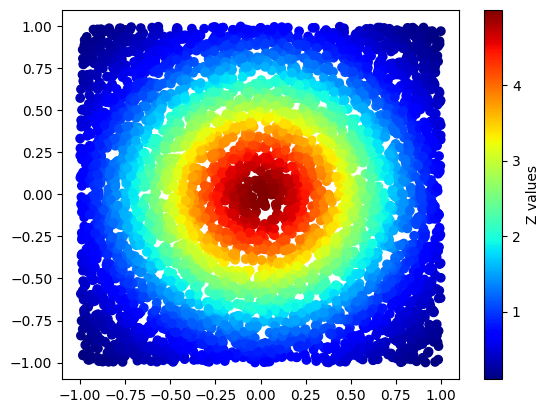

In [9]:
theta_x1_x2 = [theta_function2(df["x1"][i], df["x2"][i]) for i in range(len(df["x2"]))]
plt.scatter(df["x1"], df["x2"], c=theta_x1_x2, cmap='jet')  # 'c' sets the colors, 'cmap' is the colormap
plt.colorbar(label='Z values')
plt.show()

In [34]:
x_train = np.concatenate([x1_train[:,None], x2_train[:,None]], axis = 1)
model = FrailtyModelNN(pvf_parameters, pvf_loglikelihood_loss, pvf_neural_network, pvf_neural_network_call, input_dim = (None, 2), seed = 10)

model.train_model(x_train, t_train, delta_train,
                  epochs = 2500, shuffle = True,
                  validation = False, val_prop = 0.2,
                  optimizer_independent_pars = optimizers.Adam(learning_rate = 0.01),
                  optimizer_nn = optimizers.AdamW(learning_rate = 0.1),
                  train_batch_size = None, val_batch_size = None,
                  buffer_size = 4096, gradient_accumulation_steps = None,
                  early_stopping = True, early_stopping_min_delta = 0.0, early_stopping_patience = 10, early_stopping_warmup = 100,
                  run_eagerly = False, verbose = 1)

print("alpha: {}".format( model.get_variable("alpha") ))
print("gamma: {}".format( model.get_variable("gamma") ))
print("phi1: {}".format( model.get_variable("phi1") ))
print("phi2: {}".format( model.get_variable("phi2") ))

0epoch [00:00, ?epoch/s]

alpha: 0.6294541954994202
gamma: 0.5758070945739746
phi1: 1.9590696096420288
phi2: 0.7919819355010986


In [35]:
model.copy()

<FrailtyModelNN name=frailty_model_nn_8, built=True>

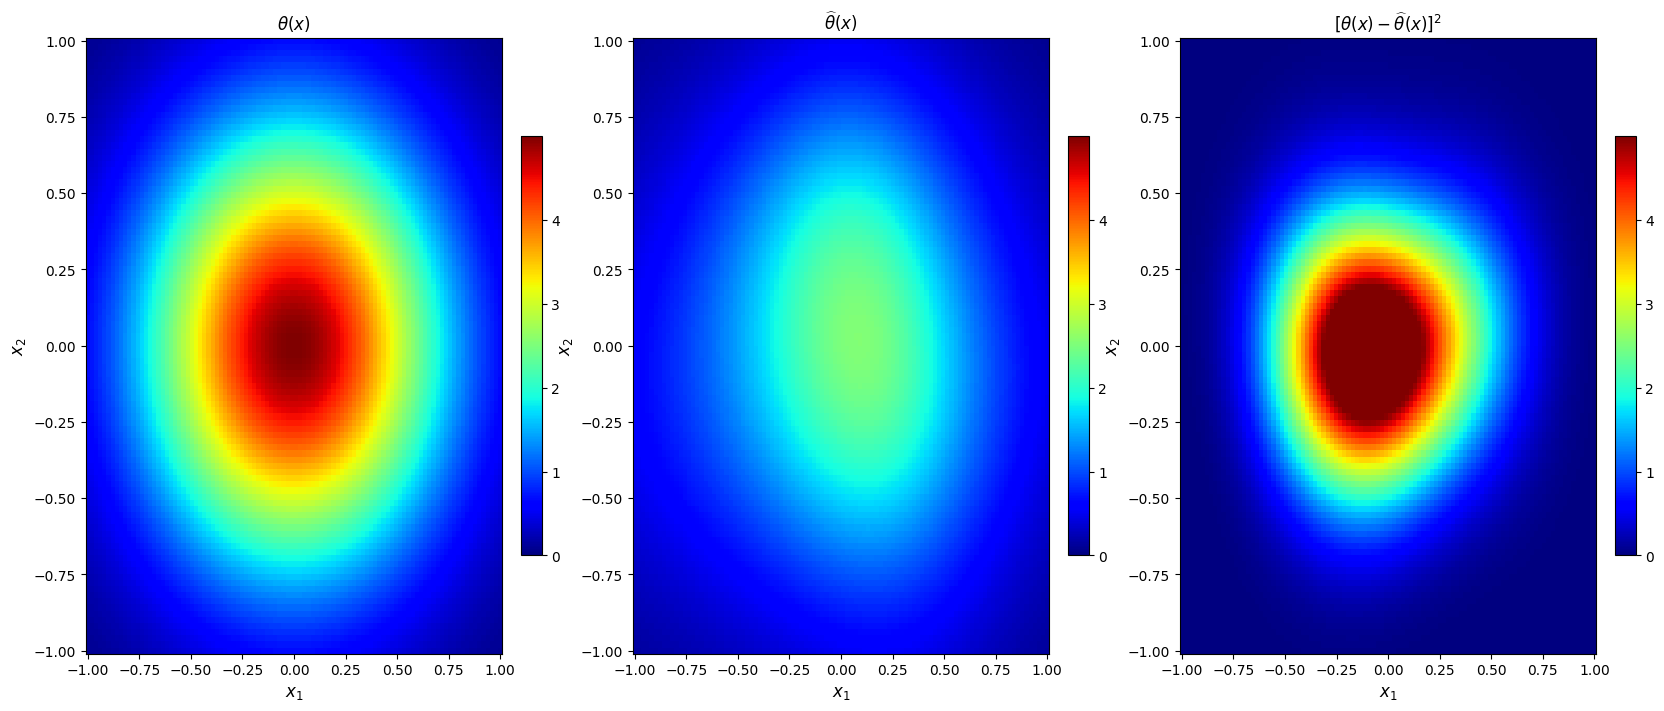

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 8))

xs1, xs2 = np.meshgrid( np.linspace(-1, 1, 100), np.linspace(-1, 1, 100) )
theta_xs1_xs2 = theta_function2(xs1, xs2)
vmin = 0.0
vmax = np.max(theta_xs1_xs2)

mesh1 = ax[0].pcolormesh(xs1, xs2, theta_xs1_xs2, cmap = "jet", vmin = vmin, vmax = vmax)
ax[0].set_title(r"$\theta(x)$")
ax[0].set_xlabel(r"$x_1$", fontsize = 12)
ax[0].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

xs1_all = xs1.flatten()
xs2_all = xs2.flatten()
theta_pred = np.exp(model.predict( np.concatenate([xs1_all[:,None], xs2_all[:,None]], axis = 1), verbose = 0 ))
theta_pred = theta_pred.reshape(xs1.shape)

mesh2 = ax[1].pcolormesh(xs1, xs2, theta_pred, cmap = "jet", vmin = vmin, vmax = vmax)
ax[1].set_title(r"$\widehat{\theta}(x)$")
ax[1].set_xlabel(r"$x_1$", fontsize = 12)
ax[1].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)

mesh3 = ax[2].pcolormesh(xs1, xs2, (theta_pred - theta_xs1_xs2)**2, cmap = "jet", vmin = vmin, vmax = vmax)
ax[2].set_title(r"[$\theta(x) - \widehat{\theta}(x)]^2$")
ax[2].set_xlabel(r"$x_1$", fontsize = 12)
ax[2].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh3, ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.show()